# Module 1 Project: King County House Sales Price Projection


In [2]:
#import libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from collections import Counter

In [3]:
kcdata = pd.read_csv("kc_house_data.csv")

In [4]:
#Data Exploration
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
#Find missing value: waterfront, view, yr_renovated
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [6]:
kcdata.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [7]:
kcdata.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [27]:
#For Categorical data 'Waterfront' and 'View', replace NAN with 0 
kcdata['waterfront'].unique()
kcdata['waterfront'] = kcdata['waterfront'].fillna(0)

counter = Counter()
counter = Counter(kcdata['waterfront'])
print(counter)

Counter({0.0: 21451, 1.0: 146})


In [29]:
kcdata['view'].unique()
kcdata['view'] = kcdata['view'].fillna(0)
counter = Counter()
counter = Counter(kcdata['view'])
print(counter)

Counter({0.0: 19485, 2.0: 957, 3.0: 508, 1.0: 330, 4.0: 317})


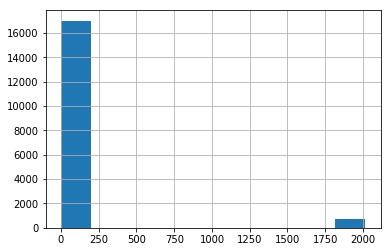

In [16]:
#There are too many missing values in yr_renovated. And it may not be fair to replace NAN with average. 
#So we will probably not consider this variable into the model.We will just  fill NAN with zero for now.
%matplotlib inline
kcdata['yr_renovated'].fillna(0)
#kcdata['yr_renovated'].hist()

In [13]:
#Categorical Data
potential_list = ['']
for i in kcdata.columns:
    print(i , kcdata[i].unique())



id [7129300520 6414100192 5631500400 ... 1523300141  291310100 1523300157]
date ['10/13/2014' '12/9/2014' '2/25/2015' '2/18/2015' '5/12/2014' '6/27/2014'
 '1/15/2015' '4/15/2015' '3/12/2015' '4/3/2015' '5/27/2014' '5/28/2014'
 '10/7/2014' '1/24/2015' '7/31/2014' '5/29/2014' '12/5/2014' '4/24/2015'
 '5/14/2014' '8/26/2014' '7/3/2014' '5/16/2014' '11/20/2014' '11/3/2014'
 '6/26/2014' '12/1/2014' '6/24/2014' '3/2/2015' '11/10/2014' '12/3/2014'
 '6/13/2014' '12/30/2014' '2/13/2015' '6/20/2014' '7/15/2014' '8/11/2014'
 '7/7/2014' '10/28/2014' '7/29/2014' '7/18/2014' '3/25/2015' '7/16/2014'
 '4/28/2015' '3/11/2015' '9/16/2014' '2/17/2015' '12/31/2014' '2/5/2015'
 '3/3/2015' '8/19/2014' '4/7/2015' '8/27/2014' '2/23/2015' '12/10/2014'
 '8/28/2014' '10/21/2014' '12/7/2014' '6/3/2014' '9/9/2014' '10/9/2014'
 '8/25/2014' '6/12/2014' '9/12/2014' '1/5/2015' '6/10/2014' '7/10/2014'
 '3/16/2015' '11/5/2014' '4/20/2015' '6/9/2014' '3/23/2015' '12/2/2014'
 '12/22/2014' '1/28/2015' '6/2/2014' '11/14/201